I will do a simple simulation of a speckle pattern and use a contrast estimator to estimate the contrast. From there I'll add complexity/realism, bit by bit!

Remember:
* M = 1.0 / contrast
* p = 1.0 / (k_bar/M + 1.0)

In [145]:
%pylab inline
from speckle import contrast
from scipy import ndimage
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(10, 704, 768)


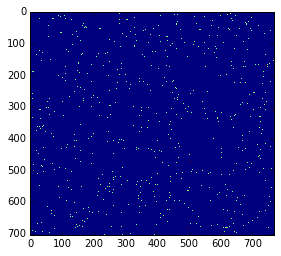

In [146]:
# negative binomial
n_shots = 10
shp     = (352*2, 384*2) # one epix

k_bar = 0.01 # expected photons per pixel
beta  = 0.5  # using 1/M definition

imgs = contrast.negative_binomial_samples(k_bar, beta, size=(n_shots, shp[0], shp[1]))
print imgs.shape

figure()
imshow(imgs[0], interpolation='nearest')
show()

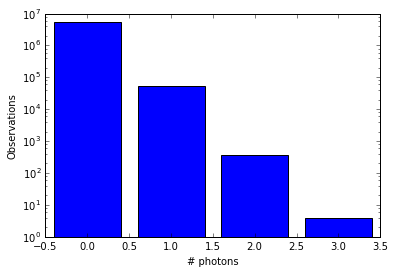

In [76]:
# hawt. lets estimate the contrast
photon_hist = np.bincount(imgs.flatten())

figure()
bar(arange(photon_hist.shape[0]) - 0.4, photon_hist)
yscale('log')
xlabel('# photons')
ylabel('Observations')
show()

In [77]:
B_ml  = contrast.fit_negative_binomial_from_hist(photon_hist, method='ml')
B_lsq = contrast.fit_negative_binomial_from_hist(photon_hist, method='lsq')
B_xp  = contrast.fit_negative_binomial_from_hist(photon_hist, method='expansion')

# note: the second number returned is an error... unfortunately it's not reliable. Just ignore for now. Will fix.

print 'ML estimate:                   %.2f' % B_ml[0]
print 'Least squares estimate:        %.2f' % B_lsq[0]
print 'Low order expansion estimate:  %.2f' % B_xp[0]

ML estimate:                   0.39
Least squares estimate:        0.39
Low order expansion estimate:  0.38


We can see there is some *statistical* error simply due to the low number of samples (= pixels * shots). With the above tools, however, it is easy to do bigger/more complete simulations of the estimator performance in k_bar/contrast/#samples space. We want something that works well across all contrast values at low k_bar, and if possible, low sample number. Getting lots of statistics is pretty easy for us though :).

Next: we can try an intermediate contrast generated by summing shots.

(20, 704, 768)
(10, 704, 768)


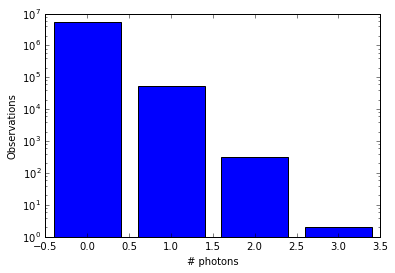

ML estimate:                   0.21
Least squares estimate:        0.21
Low order expansion estimate:  0.21
>>> that comes out to 4.7 modes, expect 4.0


In [130]:

n_shots_to_sum = 2
imgs = contrast.negative_binomial_samples(k_bar / n_shots_to_sum, 
                                          beta, 
                                          size=(n_shots * n_shots_to_sum, shp[0], shp[1]))

# this (opaque) line sums every "n_shots_to_sum" together
print imgs.shape
imgs = np.array( [ np.sum(imgs[x::n_shots,:,:], axis=0) for x in range(n_shots) ] )
print imgs.shape

photon_hist = np.bincount(imgs.flatten())

figure()
bar(arange(photon_hist.shape[0]) - 0.4, photon_hist)
yscale('log')
xlabel('# photons')
ylabel('Observations')
show()

B_ml  = contrast.fit_negative_binomial_from_hist(photon_hist, method='ml')
B_lsq = contrast.fit_negative_binomial_from_hist(photon_hist, method='lsq')
B_xp  = contrast.fit_negative_binomial_from_hist(photon_hist, method='expansion')

print 'ML estimate:                   %.2f' % B_ml[0]
print 'Least squares estimate:        %.2f' % B_lsq[0]
print 'Low order expansion estimate:  %.2f' % B_xp[0]

print '>>> that comes out to %.1f modes, expect %.1f' % (1.0 / B_ml[0], n_shots_to_sum / beta)


Cool! OK, now let's use a random phasor model to get something with some spatial detail...

978


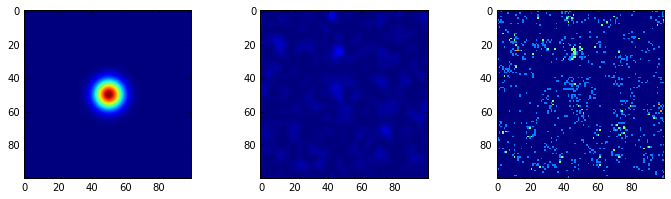

In [155]:
new_shp     = (100, 100)
avg_photons = 1000
beam_size   = 8 # stds

X, Y = indices(new_shp) - (np.array(new_shp) / 2.0)[:,None,None]
beam = np.exp(-((X)**2 + (Y)**2) / beam_size**2)

random_phase = exp(2 * pi * 1j * np.random.rand(*new_shp))

speckle = square(abs(fftshift(fft2(beam * random_phase))))
speckle *= (avg_photons / speckle.sum())
speckle_sample = np.random.poisson(speckle)
print np.sum(speckle_sample)

figure(figsize=(12,3))
subplot(131)
imshow(beam)
subplot(132)
imshow(speckle, interpolation='nearest', vmax=10)
subplot(133)
imshow(speckle_sample, interpolation='nearest')
show()

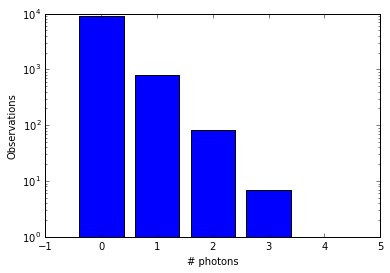

f(a) and f(b) must have different signs
ML estimate:                   0.00
Least squares estimate:        1.34
Low order expansion estimate:  1.43


In [158]:
photon_hist = np.bincount(speckle_sample.flatten())

figure()
bar(arange(photon_hist.shape[0]) - 0.4, photon_hist)
yscale('log')
xlabel('# photons')
ylabel('Observations')
show()

B_ml  = contrast.fit_negative_binomial_from_hist(photon_hist, method='ml')
B_lsq = contrast.fit_negative_binomial_from_hist(photon_hist, method='lsq')
B_xp  = contrast.fit_negative_binomial_from_hist(photon_hist, method='expansion')

# note: the second number returned is an error... unfortunately it's not reliable. Just ignore for now. Will fix.

print 'ML estimate:                   %.2f' % B_ml[0]
print 'Least squares estimate:        %.2f' % B_lsq[0]
print 'Low order expansion estimate:  %.2f' % B_xp[0]

Moving right along to adding some *random* but non-statistical error. First, gaussian noise and 18 um RMS photon charge-cloud bleeding.

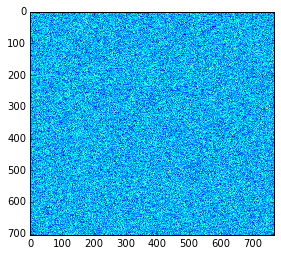

In [78]:
blur_sigma  = 18.0 / 50.0 # 18 um in "epix pixel units"
noise_sigma = 0.25        # "photons" (assume image is divided by ADU/photon)

imgs = imgs.astype(np.float)

for i in range(imgs.shape[0]):
    imgs[i] = ndimage.gaussian_filter(imgs[i], blur_sigma)
    
imgs += np.random.normal(0, noise_sigma, size=imgs.shape)

figure()
imshow(imgs[0], interpolation='nearest')
show()

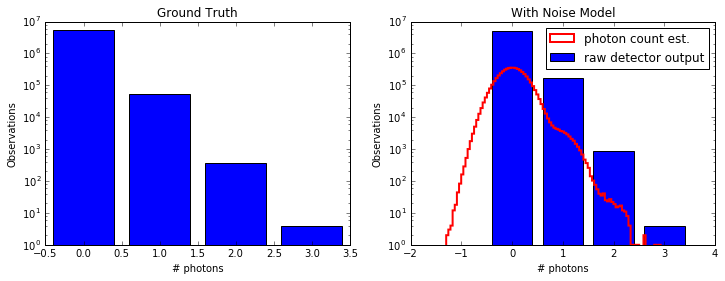

In [80]:
# do a naieve photon estimate, just rounding and ignoring negatives
noisy_photon_est  = np.round(imgs.flatten()).astype(np.int)
noisy_photon_est[noisy_photon_est < 0] = 0
noisy_photon_hist = np.bincount( noisy_photon_est )

figure(figsize=(12,4))

subplot(121)
title('Ground Truth')
bar(arange(photon_hist.shape[0]) - 0.4, photon_hist)
yscale('log')
xlabel('# photons')
ylabel('Observations')

subplot(122)
title('With Noise Model')
bar(arange(photon_hist.shape[0]) - 0.4, noisy_photon_hist)
hist(imgs.flatten(), 100, histtype='step', lw=2, color='r')
legend(['photon count est.', 'raw detector output'])
yscale('log')
xlabel('# photons')
ylabel('Observations')

show()

In [81]:
# try again!

B_ml  = contrast.fit_negative_binomial_from_hist(noisy_photon_est, method='ml')
B_lsq = contrast.fit_negative_binomial_from_hist(noisy_photon_est, method='lsq')
B_xp  = contrast.fit_negative_binomial_from_hist(noisy_photon_est, method='expansion')

print 'ML estimate:                   %.2f' % B_ml[0]
print 'Least squares estimate:        %.2f' % B_lsq[0]
print 'Low order expansion estimate:  %.2f' % B_xp[0]

ML estimate:                   0.57
Least squares estimate:        0.00
Low order expansion estimate:  nan


The behavior of these estimators in the presence of non-statistical -- especially systematic -- error is not well studied. Appreciate any insights people find.

Moving even further... let's see what the effect of looking at a realistic gold simulation is!

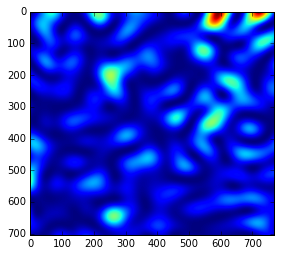

In [82]:
gold = np.load('gold_speckle.npy')
imshow(gold)

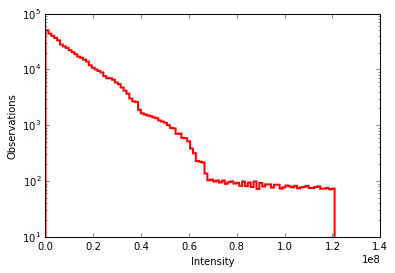

In [85]:
# expecting exponential stats
figure()
hist(gold.flatten(), 100, histtype='step', lw=2, color='r')
yscale('log')
xlabel('Intensity')
ylabel('Observations')
show()

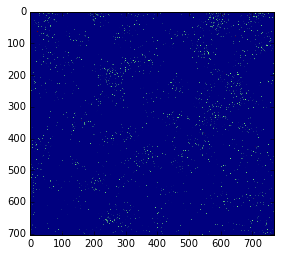

In [106]:
gold_samples = np.random.poisson(gold * k_bar * np.product(gold.shape) / gold.sum())    
imshow(gold_samples)

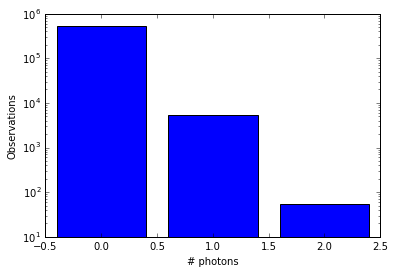

In [107]:
# hawt. lets estimate the contrast
gold_photon_hist = np.bincount(gold_samples.flatten())

figure()
bar(arange(gold_photon_hist.shape[0]) - 0.4, gold_photon_hist)
yscale('log')
xlabel('# photons')
ylabel('Observations')
show()

In [108]:
B_ml  = contrast.fit_negative_binomial_from_hist(gold_photon_hist, method='ml')
B_lsq = contrast.fit_negative_binomial_from_hist(gold_photon_hist, method='lsq')
B_xp  = contrast.fit_negative_binomial_from_hist(gold_photon_hist, method='expansion')

print 'ML estimate:                   %.2f' % B_ml[0]
print 'Least squares estimate:        %.2f' % B_lsq[0]
print 'Low order expansion estimate:  %.2f' % B_xp[0]

f(a) and f(b) must have different signs
ML estimate:                   0.00
Least squares estimate:        1.09
Low order expansion estimate:  1.12


In [110]:
# seems the ML estimator freaks out if the estimated contrast would be > 1.0, 
# which may be bad for very high contrast samples